# Perspective Projection: Distance Estimation

## The Pinhole Camera Model
In computer vision and robotics typically an idealized model of the camera is used - *the pinhole camera model*. Light from the scene passes through an infinitely small hole and an inverted image is projected onto the opposite site of the box. 
To facilitate the visualisation, it is assumed that the projected image is formed on an imaginary image plane in front of the projection center. Then, the image is not longer upside-down.

<p align="center">
  <img height="300" src="imgs/pinhole.png">
</p>

## Perspective Projection
While we are moving through the world, we only perceive a projection of the 3D world onto our eye's retina or the robot perceives a projection of the 3D world onto its camera sensor. This has the effect that object that are close appear larger on the projected picture plane than objects at greater distance. 

This tutorial will provide further insights into the relationship between distance and perceived object size. Knowing the size of an object in the real world, will allow us to calculate the absolut distance to that object. Which assumptions are made? How is the observed error distributed? The following assignment will guide you through analytical methods of distance estimation via perspective projection.

<p align="center">
  <img height="300" src="imgs/perspective.png">
</p>

# Coding: Getting Started
Before you get started you need to follow the descriptions of the Git-Repository and make sure that all required packages are properly installed. It is recommended to work in a virtual environment. Start your virtual environment **before** you launch this jupyter-notebook. Then you may need to change the kernel: *Kernel &rarr; Change kernel &rarr; venv*

In [1]:
import torch
import cv2
import os 
import glob
import argparse
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
YOLO_MODEL = './model/yolo_model.pt'
FILE = '../../data/test/img/2023-6-28_17-06-35-343099.png'
PATH = '../../data/train/img'
PATH_CSV = '../../data/train/train.csv'
ROBOTS = ["ollie", "grace", "alan", "hermann", "kaethe"]
CAM_ROBOT = "ollie"
DEVICE = "cpu"
FILE_EXTENSION = "*.png"
ROBOT_HEIGHT_M = 0.09
FOCALLENGTH_PX = 627.590698 
CONFIDENCE = 0.75

In [3]:
# Loading YOLOv5 Model
model_YOLO = torch.hub.load('ultralytics/yolov5', 'custom', path=YOLO_MODEL, verbose=False)
model_YOLO.conf = CONFIDENCE
model_YOLO.to(DEVICE)

YOLOv5 🚀 2023-8-13 Python-3.11.4 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

## Part 1.1: Projected Object Size and Distance

The provided code automatically detects little Lego Robots in an image. For detection we use a fine-tuned YOLOv5 network that estimates bounding boxes, that each capture the rough dimensions of the projected object.
Given the height of an object bounding box, the camera's focal length as well as the actual robot's height we compute the absolut distance between "CAM_ROBOT" and all visible robots in the image.

In [4]:
def dist(box, focallength_px, robot_height_m):
    
    ####################################################
    # TODO 1:
    # please fill in the code to compute 
    # the distance from the bounding box height

    distance = 0
    
    F1 = math.sqrt(focallength_px**2 + (box[3]-240)**2 + (box[0]-320)**2)
    F2 = math.sqrt(focallength_px**2 + (box[1]-240)**2 + (box[2]-320)**2)
    b = box[3]/F1 - box[1]/F2
    distance = robot_height_m / b

    ####################################################
    
    return distance

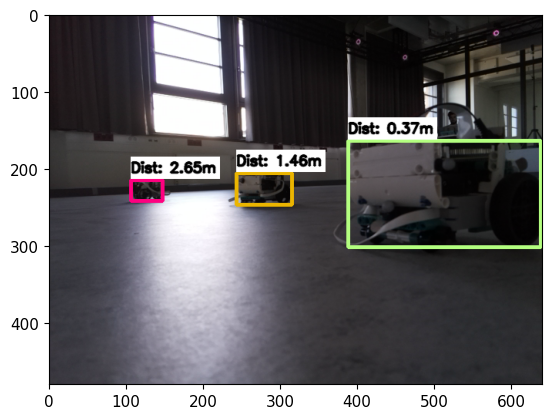

In [6]:
res = model_YOLO(FILE)

bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]
image = cv2.imread(FILE)
color = iter(cm.rainbow(np.linspace(0, 1, 5)))

for box in bounding_boxes:

    ####################################################
    # TODO 1:
    # please fill in the code to compute 
    # the distance from the bounding box height

    distance = dist(box, FOCALLENGTH_PX, ROBOT_HEIGHT_M)
    
    ####################################################
    
    c = next(color)
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), c[0:3]*255, 3)
    image_with_rectangle = cv2.rectangle(image, (int(box[0]), int(box[1])-30), (int(box[0]) + 115, int(box[1]-2)), (255,255,255), -1)
    img_drawn = cv2.putText(image, f"Dist: {(distance):.2f}m", (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2, cv2.LINE_AA)
    image_rgb = cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB)

# visualize frame with overlayed 
# bounding boxes and distance estimates
%matplotlib inline

fig = plt.figure()
plt.imshow(image_rgb)
plt.show()

## Part 1.2: Visualization

... now let's run this code on several consequtive frames and visualize the relationship between object height and its distance.

In [7]:
print("Loading Pictures...")

file_pattern = os.path.join(PATH, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

print("Reading pictures...")

values = {}

for i, file in enumerate(picture_files):

    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    for box in bounding_boxes:
        
        distance = dist(box, FOCALLENGTH_PX, ROBOT_HEIGHT_M)

        values.setdefault(distance, []).append(box[3] - box[1])

Loading Pictures...
Reading pictures...


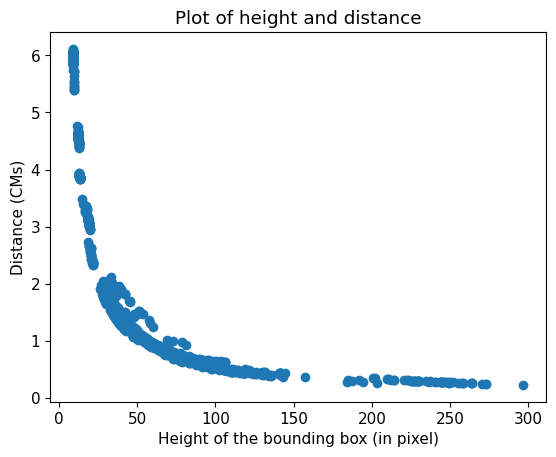

In [8]:
x = []
y = []

for dist in values:
    for height in values[dist]:
        x.append(height.item())
        y.append(dist)

plt.scatter(x, y)

plt.xlabel('Height of the bounding box (in pixel)')
plt.ylabel('Distance (CMs)')
plt.title('Plot of height and distance')

plt.show()

## Part 2.1: Evaluation

Groudtruth robot poses were captured with a motion capture system for all robots visible in this data. Poses were saved in the provided .csv file. In this part of the tutorial let's anayse the observed error. How does this relate to the object's distance? What are possible causes of this error?

In [9]:
# get list of picture files in PATH
file_pattern = os.path.join(PATH, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

# read csv file with ground truth robot poses
df = pd.read_csv(PATH_CSV, header=None)

# get column for each robot in csv file
row = df.iloc[0].to_numpy()
robot_col = {}
for rbo in ROBOTS:
    bool_array = row == rbo
    robot_col[rbo] = bool_array.argmax()
cam_robot_col = robot_col[CAM_ROBOT]

err = []
distance_x = []

for i, file in enumerate(picture_files):

    # -----------------------------------------------------------------
    # LOAD GROUNDTRUTH DISTANCES FOR EACH PICTURE
    # -----------------------------------------------------------------
    
    row_val = os.path.basename(file)
    row_matching_value = df[df.iloc[:, 0] == row_val]
    print("********")
    print(row_val)

    if row_matching_value.empty:
        print("Skipping, since no matching image name in csv")
        continue

    row = row_matching_value.index[0]

    if type(df.at[row,2]) is not str and math.isnan(df.at[row,2]):
        print("Skipping, since no robots visable on image ")
        continue
       
    # robots present in current frame
    robot_list = df.at[row,2].split()
    
    distance_gt = []
    
    for robot in zip(robot_list):
        
        # pose of the camera robot
        camX = df.at[row,cam_robot_col+2]
        camY = df.at[row,cam_robot_col]

        # pose of neighboring robot
        robotX = df.at[row, robot_col[robot[0]] + 2]
        robotY = df.at[row, robot_col[robot[0]]]

        # GROUNDTRUTH DISTANCE
        distance = np.sqrt((float(robotX)-float(camX)) ** 2 + (float(robotY)-float(camY)) ** 2)
        distance = distance / 100
        
        print(f"distance_gt: {distance}")
        
        distance = torch.tensor(distance, dtype = torch.float32,)
        distance_gt.append(distance)
        
    # -----------------------------------------------------------------
    # COMPUTE DISTANCE FROM BOUNDING BOX HEIGHT
    # -----------------------------------------------------------------
    
    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    distance_estim = []
    
    for box in bounding_boxes:
        
        bbh = box[3] - box[1]
        distance = FOCALLENGTH_PX * ROBOT_HEIGHT_M / bbh
        distance_estim.append(distance)
        
        print(f"distance_estim: {distance}")
        
    # -----------------------------------------------------------------
    # COMPUTE ERROR
    # -----------------------------------------------------------------
    
    if(bounding_boxes.shape[0] == len(robot_list)):

        error = abs(np.array(distance_gt) - np.array(distance_estim))
        err.extend(error)
        distance_x.extend(distance_gt)

********
2023-6-28_17-14-45-756992.png
distance_gt: 0.3155240818351403
distance_gt: 3.778328848866088
distance_gt: 4.927410998490273
distance_gt: 3.678965914334902
distance_estim: 0.2349800020456314
distance_estim: 4.7148919105529785
distance_estim: 6.507396697998047
distance_estim: 4.287359714508057
********
2023-6-28_17-14-45-798767.png
distance_gt: 0.31194829970741805
distance_gt: 3.7783595390285143
distance_gt: 4.927295745423304
distance_gt: 3.6790048635242454
distance_estim: 0.23412726819515228
distance_estim: 4.729312896728516
distance_estim: 6.483461380004883
distance_estim: 4.306072235107422
********
2023-6-28_17-14-45-840106.png
distance_gt: 0.30869088965782093
distance_gt: 3.778347856993213
distance_gt: 4.927295763400836
distance_gt: 3.6789836432355405
distance_estim: 0.21446558833122253
distance_estim: 4.722663402557373
distance_estim: 6.451775550842285
distance_estim: 4.3019185066223145
********
2023-6-28_17-14-45-885886.png
distance_gt: 0.3055268779027879
distance_gt: 3.77

distance_estim: 0.2506166398525238
distance_estim: 4.651661396026611
distance_estim: 6.540926456451416
distance_estim: 4.303999423980713
********
2023-6-28_17-14-47-168362.png
distance_gt: 0.32324607871646654
distance_gt: 3.778339445175189
distance_gt: 4.927392924619998
distance_gt: 3.678974170378526
distance_estim: 0.24946731328964233
distance_estim: 4.669558525085449
distance_estim: 6.386744499206543
distance_estim: 4.3629255294799805
********
2023-6-28_17-14-47-211557.png
distance_gt: 0.32322930159145424
distance_gt: 3.7783174662471963
distance_gt: 4.927398296299151
distance_gt: 3.678968509677135
distance_estim: 0.24549409747123718
distance_estim: 4.681582927703857
distance_estim: 6.425301551818848
distance_estim: 4.310324192047119
********
2023-6-28_17-14-47-256633.png
distance_gt: 0.32323189169245553
distance_gt: 3.778329409814662
distance_gt: 4.927403364080032
distance_gt: 3.678968396950067
distance_estim: 0.250050812959671
distance_estim: 4.644191265106201
distance_estim: 6.4561

distance_estim: 2.995774269104004
distance_estim: 4.490521430969238
distance_estim: 6.371222972869873
distance_estim: 4.3747124671936035
********
2023-6-28_17-14-58-699808.png
distance_gt: 2.258751636468169
distance_gt: 3.7783366514346204
distance_gt: 4.927286394674891
distance_gt: 3.6789599483939406
distance_estim: 2.9923884868621826
distance_estim: 4.4751362800598145
distance_estim: 6.300625324249268
distance_estim: 4.382938385009766
********
2023-6-28_17-14-58-742529.png
distance_gt: 2.2585376317997254
distance_gt: 3.7783548197490653
distance_gt: 4.927398491952696
distance_gt: 3.678964202703154
distance_estim: 2.980855941772461
distance_estim: 4.456215858459473
distance_estim: 6.315697193145752
distance_estim: 4.366847038269043
********
2023-6-28_17-14-58-825925.png
distance_gt: 2.261682626478862
distance_gt: 3.7783517018939103
distance_gt: 4.927253257304559
distance_gt: 3.678970124270775
distance_estim: 3.0052108764648438
distance_estim: 4.5111083984375
distance_estim: 6.3189744949

distance_estim: 2.940885305404663
distance_estim: 4.64800500869751
distance_estim: 6.356802463531494
distance_estim: 4.381433963775635
********
2023-6-28_17-15-00-506288.png
distance_gt: 2.3838832052649495
distance_gt: 3.7783706975798244
distance_gt: 4.927389178984584
distance_gt: 3.678963309142382
distance_estim: 2.947972536087036
distance_estim: 4.64254903793335
distance_estim: 6.4144792556762695
distance_estim: 4.360489368438721
********
2023-6-28_17-15-00-588797.png
distance_gt: 2.383848647702705
distance_gt: 3.778349528308238
distance_gt: 4.927396851290284
distance_gt: 3.6789622461241542
distance_estim: 2.97887921333313
distance_estim: 4.666168212890625
distance_estim: 6.351719379425049
distance_estim: 4.385524272918701
********
2023-6-28_17-15-00-630440.png
distance_gt: 2.382986662159745
distance_gt: 3.7783543153323844
distance_gt: 4.927290445352865
distance_gt: 3.6789708320898784
distance_estim: 3.0673470497131348
distance_estim: 4.639697074890137
distance_estim: 6.4176154136657

distance_estim: 4.709852695465088
distance_estim: 2.76493239402771
distance_estim: 6.051127910614014
distance_estim: 4.342789173126221
********
2023-6-28_17-15-06-429339.png
distance_gt: 3.7783542654194724
distance_gt: 4.927369863881847
distance_gt: 2.0936004653700286
distance_gt: 3.678960989807741
distance_estim: 4.6454620361328125
distance_estim: 5.887252330780029
distance_estim: 2.6239283084869385
distance_estim: 4.347849369049072
********
2023-6-28_17-15-06-470646.png
distance_gt: 3.77831475834459
distance_gt: 4.927385481452974
distance_gt: 2.094761934962127
distance_gt: 3.678962398778736
distance_estim: 4.674323081970215
distance_estim: 5.857145309448242
distance_estim: 2.611945390701294
distance_estim: 4.344756603240967
********
2023-6-28_17-15-06-512030.png
distance_gt: 3.7783282560920144
distance_gt: 4.927351754779194
distance_gt: 2.0968341791079608
distance_gt: 3.6789512913475813
distance_estim: 4.6658034324646
distance_estim: 5.795230865478516
distance_estim: 2.61699390411376

distance_estim: 0.6262136697769165
distance_estim: 2.0109894275665283
********
2023-6-28_17-15-29-873483.png
distance_gt: 0.6095201936627203
distance_gt: 1.8050675774515783
distance_estim: 0.6216801404953003
distance_estim: 1.9813157320022583
********
2023-6-28_17-15-29-917989.png
distance_gt: 0.6060711378685345
distance_gt: 1.801893038845181
distance_estim: 0.6158658862113953
distance_estim: 1.959817886352539
********
2023-6-28_17-15-30-009681.png
distance_gt: 0.6057867653953537
distance_gt: 1.8016117957071691
distance_estim: 0.6133151054382324
distance_estim: 1.9758797883987427
********
2023-6-28_17-15-30-054875.png
distance_gt: 0.6044867622732721
distance_gt: 1.800400048588169
distance_estim: 0.6024190187454224
distance_estim: 1.9035202264785767
********
2023-6-28_17-15-30-097406.png
distance_gt: 0.6003773228573945
distance_gt: 1.796488183316618
distance_estim: 0.5952726602554321
distance_estim: 1.8685824871063232
********
2023-6-28_17-15-30-140736.png
distance_gt: 0.594302742584741

distance_estim: 0.9964956641197205
********
2023-6-28_17-15-34-717551.png
distance_gt: 0.798276629022042
distance_estim: 0.9504316449165344
********
2023-6-28_17-15-34-760619.png
distance_gt: 0.7852130180841624
distance_estim: 0.929467499256134
********
2023-6-28_17-15-34-803394.png
distance_gt: 0.7713123867621424
distance_estim: 0.9177623391151428
********
2023-6-28_17-15-34-845986.png
distance_gt: 0.7578807243993309
distance_estim: 0.8904072642326355
********
2023-6-28_17-15-34-888824.png
distance_gt: 0.7436722456629627
distance_estim: 0.8792778253555298
********
2023-6-28_17-15-34-931719.png
distance_gt: 0.7303218969391899
distance_estim: 0.8663288950920105
********
2023-6-28_17-15-34-974702.png
distance_gt: 0.716877970225446
distance_estim: 0.8482091426849365
********
2023-6-28_17-15-35-060258.png
distance_gt: 0.6889715645247176
distance_estim: 0.7856225371360779
********
2023-6-28_17-15-35-103224.png
distance_gt: 0.674616213798465
distance_estim: 0.7722246646881104
********
2023-6

distance_estim: 0.2809866964817047
********
2023-6-28_17-15-39-925500.png
distance_gt: 0.30107564275704435
distance_estim: 0.29452598094940186
********
2023-6-28_17-15-40-005779.png
distance_gt: 0.3134680135468448
distance_estim: 0.30173259973526
********
2023-6-28_17-15-40-047015.png
distance_gt: 0.32033713348177045
distance_estim: 0.3058614134788513
********
2023-6-28_17-15-40-167489.png
distance_gt: 0.34314448240936934
distance_estim: 0.3071366548538208
********
2023-6-28_17-15-40-330399.png
distance_gt: 0.37411660501172117
********
2023-6-28_17-15-40-371160.png
distance_gt: 0.3819897236581696
********
2023-6-28_17-15-40-412057.png
distance_gt: 0.391103362214061
********
2023-6-28_17-15-40-455071.png
distance_gt: 0.39984558534245784
distance_estim: 0.4144705533981323
********
2023-6-28_17-15-40-497657.png
distance_gt: 0.410970209776662
distance_estim: 0.431850403547287
********
2023-6-28_17-15-40-582345.png
distance_gt: 0.4311185679737871
distance_estim: 0.42118898034095764
********

distance_estim: 1.5597857236862183
distance_estim: 1.893810749053955
********
2023-6-28_17-15-50-845550.png
distance_gt: 1.3888597808015481
distance_gt: 1.6880895747814588
distance_estim: 1.5797637701034546
distance_estim: 1.913642168045044
********
2023-6-28_17-15-50-888110.png
distance_gt: 1.3890675635005174
distance_gt: 1.6884590921234988
distance_estim: 1.5781084299087524
distance_estim: 1.9373691082000732
********
2023-6-28_17-15-50-928950.png
distance_gt: 1.3863344245002225
distance_gt: 1.6855399459686324
distance_estim: 1.5451390743255615
distance_estim: 1.9650425910949707
********
2023-6-28_17-15-51-012391.png
distance_gt: 1.3788139766726966
distance_gt: 1.6774886230948431
distance_estim: 1.5590972900390625
distance_estim: 1.951249599456787
********
2023-6-28_17-15-51-101113.png
distance_gt: 1.3782940482524517
distance_gt: 1.6768364559967504
distance_estim: 1.5534024238586426
distance_estim: 1.9914933443069458
********
2023-6-28_17-15-51-231808.png
distance_gt: 1.37817533833183

distance_estim: 0.5914345383644104
********
2023-6-28_17-15-56-221482.png
distance_gt: 0.5206142723100619
distance_estim: 0.5918816328048706
********
2023-6-28_17-15-56-261686.png
distance_gt: 0.5189490648833527
distance_estim: 0.561923086643219
********
2023-6-28_17-15-56-340235.png
distance_gt: 0.5148849378173371
distance_estim: 0.5492546558380127
********
2023-6-28_17-15-56-420033.png
distance_gt: 0.5095117488146952
distance_estim: 0.5371050238609314
********
2023-6-28_17-15-56-460045.png
distance_gt: 0.5053294273077471
distance_estim: 0.539282500743866
********
2023-6-28_17-15-56-500321.png
distance_gt: 0.4988314934032443
distance_estim: 0.5290455222129822
********
2023-6-28_17-15-56-541168.png
distance_gt: 0.49306194519570534
distance_estim: 0.5123707056045532
********
2023-6-28_17-15-56-581888.png
distance_gt: 0.4897842965792691
distance_estim: 0.5195754170417786
********
2023-6-28_17-15-56-664965.png
distance_gt: 0.49047862577412976
distance_estim: 0.5122348666191101
********
20

distance_estim: 0.4481120705604553
********
2023-6-28_17-16-06-357940.png
distance_gt: 0.41560126498262806
distance_estim: 0.43442273139953613
********
2023-6-28_17-16-06-398790.png
distance_gt: 0.4025548829998872
distance_estim: 0.40049228072166443
********
2023-6-28_17-16-06-523712.png
distance_gt: 0.36292329688424396
distance_estim: 0.35939523577690125


## Part 2.2: Visualization
...now let's visualize again.

torch.Size([])
(1,)


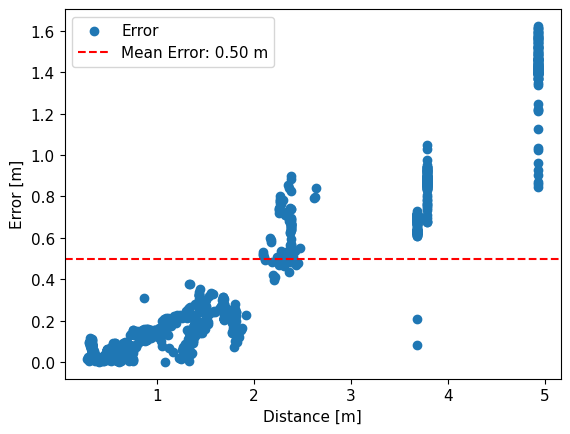

In [10]:
print(distance.shape)
print(error.shape)

plt.scatter(distance_x, err, label='Error')
mean_err = np.mean(err)
plt.axhline(y=mean_err, color='r', linestyle='--', label=f'Mean Error: {mean_err:.2f} m')

# Adding labels and title
plt.xlabel('Distance [m]')
plt.ylabel('Error [m]')

# Display the plot
plt.legend()
plt.show(block=True)

## Question 1:
Please describe the behavior of the error. What are possible causes for errors that you observe? (Please name at least three causes)

*Answer:*